d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


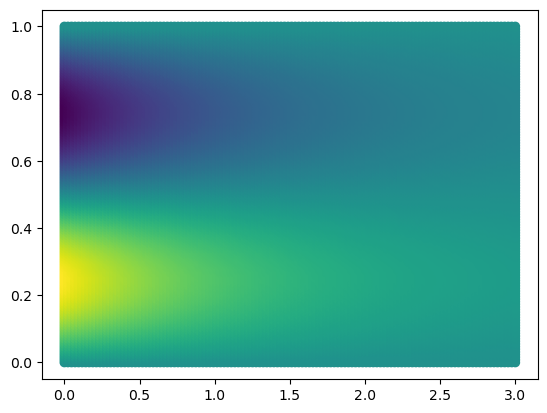

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad
from user_funn.geom import line_linspace

# define question
n = 2
a = 0.02
L = 1
tmax = 3

# get ana-solution
import heat_benchmark 
bm = heat_benchmark.HeatBenchMark(n,a,L,tmax)
X,y_true = bm.gen_testdata()
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c = y_true)


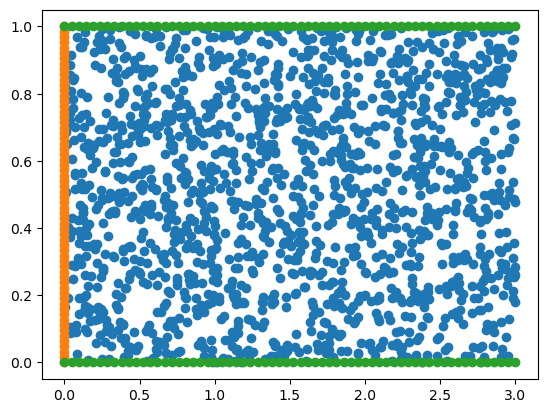

In [2]:
# 保证迭代参数与DEEPXDE一致
from socket import TCP_MAXSEG


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

t_length = 3

## define a pde
pde_epoch_size = 1600
pde_input = D2Field([0,t_length],[0,L]).get_field_rand(pde_epoch_size)
pde_output = np.zeros([pde_epoch_size,1])

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)

    # 数据提取
    t = x_in[:,[0]]
    x = x_in[:,[1]]
    u = U[:,[0]]

    # 计算一阶导
    dudi = grad(u, x_in)[0]
    dudt = dudi[:,[0]]
    dudx = dudi[:,[1]]
    # 计算二阶导
    du2dxi = grad(dudx, x_in)[0]
    du2dx2 = du2dxi[:,[1]]

    loss = dudt - a * du2dx2
    loss = loss_fn(loss, y_real)
    return loss

## boss tc and bc
from user_funn.bc import data_loss_factory

## define a tc
tc_epoch_size = 64
tc_input = line_linspace([0,0],[0,L],tc_epoch_size)
tc_t = tc_input[:,0]
tc_x = tc_input[:,1]
tc_output = np.sin(n * np.pi * tc_x / L).reshape(tc_epoch_size,1)
tc_loss = data_loss_factory(loss_fn,[0])

## define a bc
bc_epoch_size = 64
bc_input1 = line_linspace([0,0],[tmax,0],bc_epoch_size)
bc_input2 = line_linspace([0,L],[tmax,L],bc_epoch_size)
bc_input = np.vstack([bc_input1,bc_input2])
bc_output = np.zeros([bc_epoch_size*2 ,1])
bc_loss = data_loss_factory(loss_fn,[0])

solver = CloudPointSolver(
    [[pde_input, pde_output],[tc_input,tc_output],[bc_input, bc_output]],
    [pde_loss,tc_loss,bc_loss],
    model = [2, 100, 100, 100, 1],
    optimizer = "adam",
    batchsize = [pde_epoch_size, tc_epoch_size, bc_epoch_size])

import user_funn.plot
user_funn.plot.scatter_2d_cloud_point_kind([pde_input,tc_input,bc_input])


In [3]:

epoch_num = 3000
for i in range(epoch_num):
    solver.train_step()
    if i%100 == 0:
        solver.test_step(print_flag=True)

loss is [0.00100466 0.4461425  0.01260719 0.45975435]
loss is [0.02860075 0.24013177 0.04562024 0.31435275]
loss is [0.02019716 0.02024818 0.00559154 0.04603688]
loss is [0.00171406 0.00149176 0.0009193  0.00412511]
loss is [0.00116988 0.00113769 0.00059357 0.00290113]
loss is [0.00091084 0.00141282 0.00115945 0.00348312]
loss is [0.00076    0.00028144 0.0002422  0.00128363]
loss is [0.00064819 0.00091255 0.00110697 0.00266772]
loss is [0.00055582 0.00018141 0.00029825 0.00103548]
loss is [0.00049013 0.00014009 0.00025662 0.00088684]
loss is [4.8627533e-04 7.5141143e-05 2.4900178e-04 8.1041828e-04]
loss is [3.6165732e-04 6.1601364e-05 5.6334186e-05 4.7959288e-04]
loss is [3.3182837e-04 5.6784389e-05 6.6349399e-05 4.5496217e-04]
loss is [0.00045384 0.0023257  0.00081527 0.00359481]
loss is [2.5092467e-04 9.0867819e-05 4.4334658e-05 3.8612713e-04]
loss is [2.3147624e-04 3.6773257e-05 1.9718169e-05 2.8796765e-04]
loss is [2.2572573e-04 3.0224423e-05 2.8545282e-05 2.8449541e-04]
loss is [2

error 0.0011193887558769914


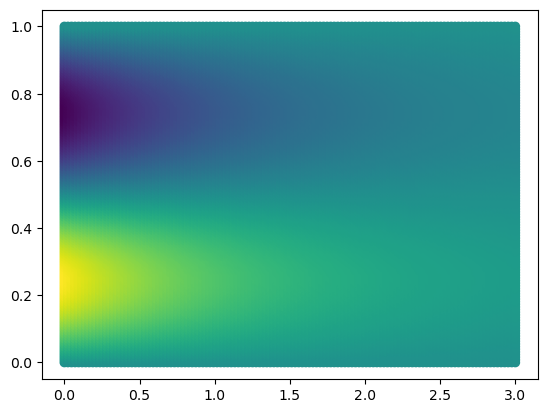

In [4]:
x_cpu,y_real = bm.gen_testdata()
y_cpu = solver.model_eval(x_cpu)
plt.scatter(x_cpu[:,0],x_cpu[:,1],c = y_cpu)
print('error',np.abs(y_real-y_cpu.detach().numpy()).std())